# Zeeman slower
This document provides all the information about how to design a Zeeman slower using a magnetic field.
Includes an optional interactive matplotlib widget that lets you vary key parameters with sliders.

## Brief theory introduction


Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = v \frac{dv}{dz} = - a$, and when we integrate over position we get the velocity profile as a function of position. Assuming constant deceleration, we can express the velocity as a function of position z along the slower as:
$$v(z) = \sqrt{v_0^2 - 2 a z}$$
where $v_0$ is the initial velocity of the atoms at the entrance of the slower, and $a$ is the constant deceleration which typically is $a=\eta a_{max}$ where eta is typically between 0.5 and 0.8.
Thus, the stopping distance L required to slow atoms from initial velocity $v_0$ to final velocity $v_f$ is given by:
$$L = \frac{v_0^2 - v_f^2}{2 a}$$

Assuming $v_f=0$ we can redefine $v(z)$ in terms of L as:
$$v(z) = v_0 \sqrt{1 - \frac{z}{L}}$$

When a beam of particles is slowed down using a counter-propagating laser beam, the particles experience a changing Doppler shift, $k v(z)$, as they decelerate, where $k$ is the wavevector of the laser light.
To maintain resonance between the laser frequency and the atomic transition, a spatially varying magnetic field, $B(z)$, is applied along the length of the slower (or a chirped laser $\omega_0 (z)$).

This magnetic field induces a Zeeman shift in the atomic energy levels, compensating for the changing Doppler shift.
$$\omega_0 \pm \frac{\mu B(z)}{\hbar} = \omega_L + k v(z)$$
where $\omega_0$ is the atomic transition frequency, $\omega_L$ is the laser frequency, $\mu$ is the Bohr magneton, and $v(z)$ is the velocity of the atoms at position z.

Hence, the ideal magnetic field profile for a Zeeman slower that maintains resonance throughout the slowing process via decreasing the field (+sign and $\sigma^+$ polarization) is given by:
$$B_+(z) = B_{bias,+} + B_0\sqrt{1-\frac{z}{L}}$$
where $B_0 = \frac{\hbar k v_0}{\mu} = \frac{h v_0}{\lambda \mu}$ is the maximum magnetic field strength at the entrance of the slower, and $B_{bias,+}$ is a constant offset magnetic field, such that $\mu B_{bias,+} = \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

Whereas the decreasing-field Zeeman slower (-sign and $\sigma^-$ polarization) is,
$$B_-(z) = B_{bias,-} + B_0\left(1-\sqrt{1-\frac{z}{L}}\right)$$
where $B_{bias,-}$ is a constant offset magnetic field, such that $\mu (B_{bias,-} + B_0)= \hbar \delta_0$ where $\delta_0 = \omega_0 - \omega_L$ is the detuning of the atomic transition frequency from the laser frequency.

In case of need to look for more spectral lines, please refer to: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Or atoms information Safranova 
https://www1.udel.edu/atom

## This code studies the decreasing-field Zeeman slower

In [20]:
%matplotlib inline

# Imports and setup
import math
import wave
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# Physical constants (SI units)
hh = 6.62607015e-34  # J*s (Planck constant)
hbar = hh / (2.0 * math.pi)
mu = 9.274009994e-24  # J/T (Bohr magneton)
amu = 1.66053906660e-27  # kg (atomic mass unit)


def compute_B_z_simple(
    L_z = .3,                    # length of the slower [m] (e.g., 0.3 m)
    wavelength=422.67276e-9,     # transition wavelength [m] (e.g., Ca-40)
    v0=500.0,                    # capture (initial) speed at z=0 [m/s]
    n_points=500,                # number of points in z grid
    B_bias=200.0e-4              # bias magnetic field [T]
):
    """Compute the constant-deceleration Zeeman-slower profile.

    Inputs:
        - mass_amu: atomic mass in amu (e.g., Ca-40)
        - wavelength: transition wavelength [m] (e.g., Ca-40)
        - gamma: natural linewidth [rad/s] (Γ = 2π × FWHM in Hz)
        - g_eff: effective Landé g-factor for Zeeman shift (user

    Model and units:

    Returns:
      - z [m], v [m/s], B [T], L [m]
    """
    # Position grid and velocity profile
    zz = np.linspace(0.0, L_z, n_points)
    vv = v0 * np.sqrt(1 - zz / L_z)

    # Zeeman field profile (detuning chosen so B(L)=0)
    B_z = B_bias + (hh * v0) / (mu * wavelength) * (1 - np.sqrt(1 - zz / L_z))

    return zz, vv, B_z, L_z


def compute_B_z_forces(mass_amu=40.078, wavelength=422.67276e-9, gamma=2*math.pi*34.6e6, g_eff=1.0,
                    v0=500.0, vf=50.0, s0=5.0, eta=0.5, n_points=500):
    m = mass_amu * amu
    k = 2 * math.pi / wavelength
    F_max = hbar * k * gamma / 2.0 * (s0 / (1.0 + s0))
    a_max = F_max / m
    a = eta * a_max
    if a <= 0:
        raise ValueError("Computed deceleration <= 0; check s0 and eta")
    if v0 <= vf:
        raise ValueError("Initial velocity v0 must be > final velocity vf")
    L = (v0*v0 - vf*vf) / (2.0*a)
    z = np.linspace(0.0, L, n_points)
    v = np.sqrt(np.maximum(0.0, v0*v0 - 2.0*a*z))
    B = 1 - (hbar * k * (v - vf)) / mu
    return z, v, B, L


def plot_profile(z_plt, v_plt, B_plt, L_plt):
    """Plot magnetic field (in Gauss) and velocity vs position.

    - Left y-axis: B(z) in Gauss (1 T = 1e4 G).
    - Right y-axis: v(z) in m/s.
    Both axes start at 0 and go to the current maximum value.
    """
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.set_xlabel("z (m)")
    ax1.set_ylabel("B (G)", color='tab:blue')
    ax1.plot(z_plt, B_plt*1e4, color='tab:blue', lw=2, label='B(z) [G]')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, ls='--', alpha=0.4)

    # Twin axis for velocity
    ax2 = ax1.twinx()
    ax2.set_ylabel("v (m/s)", color='tab:orange')
    ax2.plot(z_plt, v_plt, color='tab:orange', lw=2, label='v(z) [m/s]')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Set y-limits to start at 0 and go to a little above the current max
    try:
        max_B = np.nanmax(B_plt * 1e4)
    except Exception:
        max_B = None
    try:
        max_v = np.nanmax(v_plt)
    except Exception:
        max_v = None

    if (max_B is None) or (not np.isfinite(max_B)):
        max_B = 1.0
    if (max_v is None) or (not np.isfinite(max_v)):
        max_v = 1.0

    # Ensure positive upper limits; add 5% margin
    upper_B = max(1e-8, max_B) * 1.05
    upper_v = max(1e-8, max_v) * 1.05

    ax1.set_ylim(0.0, upper_B)
    ax2.set_ylim(0.0, upper_v)

    ax1.set_title(f"Zeeman slower profile (L = {L_plt:.3f} m)")
    plt.tight_layout()
    plt.show()


In [21]:
# Species dropdown with mass, wavelength (m), and gamma (rad/s)
species_data = {
    'Ca-40':   {'mass': 40.078,  'wavelength': 422.67276e-9, 'gamma': 2*math.pi*34.6e6},
    'Sr-88':   {'mass': 87.62,   'wavelength': 460.862e-9,    'gamma': 2*math.pi*32.0e6},
    'Rb-87':   {'mass': 86.909,  'wavelength': 780.241e-9,    'gamma': 2*math.pi*6.065e6},
    'Cs-133':  {'mass': 132.905, 'wavelength': 852.347e-9,    'gamma': 2*math.pi*5.234e6},
    'Na-23':   {'mass': 22.990,  'wavelength': 589.158e-9,    'gamma': 2*math.pi*9.79e6},
    'Yb-174':  {'mass': 173.045, 'wavelength': 398.911e-9,    'gamma': 2*math.pi*29.0e6},
}

species = w.Dropdown(
    description='Species',
    options=list(species_data.keys()),
    value='Ca-40'
)

In [22]:
# Sliders (continuous_update=False avoids flicker & overdraw)
v0 = w.FloatSlider(description="v0 (m/s)", value=500.0, min=0.0, max=1200.0, step=5.0, continuous_update=False)
L_z = w.FloatSlider(description="L_z (m)", value=0.3, min=0.0, max=1.0, step=0.01, continuous_update=False)
points = w.IntSlider(description="points", value=600, min=200, max=2000, step=50, continuous_update=False)
B_bias = w.FloatSlider(description="B_bias (G)", value=200, min=0.0, max=1000.0, step=1.0, continuous_update=False)

# Info display widgets
wavelength_label = w.HTML()
gamma_label = w.HTML()

# Output area
out = w.Output()


def update_info():
    d = species_data[species.value]
    wavelength_label.value = f"<b>λ</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label.value = f"<b>Γ/2π</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"


def refresh(change=None):
    with out:
        clear_output(wait=True)
        d = species_data[species.value]
        update_info()
        try:
            zz, vv, BB, LL = compute_B_z_simple(L_z=L_z.value, wavelength=d['wavelength'],
                                         v0=v0.value, n_points=points.value, B_bias=B_bias.value * 1e-4)
        except Exception as e:
            print("Parameter error:", e)
            return
        plot_profile(zz, vv, BB, LL)

for widget in (species, v0, L_z, points, B_bias):
    widget.observe(refresh, names='value')

# UI container
ui = w.VBox([
    w.HBox([species, wavelength_label, gamma_label]),
    w.HBox([v0, L_z, points]),
    w.HBox([B_bias])
])

# Initial render
refresh()

# Display (explicit display fixes plain text repr issues)
display(ui, out)


Output()

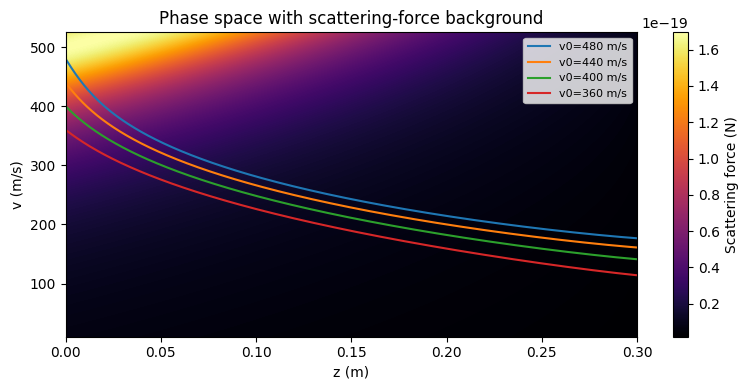

In [25]:
# Phase-space trajectories for the ideal Zeeman field profile
import numpy as np
import matplotlib.pyplot as plt

species_name = "Ca-40"
spec = species_data[species_name]
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
k = 2 * math.pi / wavelength
g_eff_val = 1.0

v_capture = 500.0  # m/s
v_final = 50.0  # m/s
s0_val = 200.0
B_bias_gauss = 200.0
L_design = 0.30

z_axis, v_profile, B_profile_T, _ = compute_B_z_simple(
    L_z=L_design,
    wavelength=wavelength,
    v0=v_capture,
    n_points=800,
    B_bias=B_bias_gauss * 1e-4,
)

# Laser detuning chosen so the entrance stays on resonance
# delta = delta_laser + k*v - g*mu*B/hbar = 0 when z=0 and v=v_capture
# => delta_laser = g*mu*B(0)/hbar - k*v_capture
delta_laser = g_eff_val * mu * B_profile_T[0] / hbar - k * v_capture


def scattering_force(B_T, velocity):
    delta = delta_laser + k * velocity - g_eff_val * mu * B_T / hbar
    denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
    return hbar * k * gamma / 2.0 * (s0_val / denom)


def integrate_trajectory(v_init):
    traj = np.zeros_like(z_axis)
    traj[0] = v_init
    for idx in range(len(z_axis) - 1):
        v_curr = max(traj[idx], 1e-6)
        dz = z_axis[idx + 1] - z_axis[idx]
        force = scattering_force(B_profile_T[idx], v_curr)
        acc = force / mass
        traj[idx + 1] = max(traj[idx] - acc * dz / v_curr, 0.0)
    return traj


vel_axis = np.linspace(v_final * 0.2, v_capture * 1.05, 400)
force_grid = np.zeros((len(z_axis), len(vel_axis)))
for i, B_val in enumerate(B_profile_T):
    delta = delta_laser + k * vel_axis - g_eff_val * mu * B_val / hbar
    denom = 1.0 + s0_val + (2.0 * delta / gamma) ** 2
    force_grid[i] = hbar * k * gamma / 2.0 * (s0_val / denom)

initial_velocities = [480.0, 440.0, 400.0, 360.0]

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(
    force_grid.T,
    extent=[z_axis[0], z_axis[-1], vel_axis[0], vel_axis[-1]],
    origin="lower",
    aspect="auto",
    cmap="inferno",
)
for v_init in initial_velocities:
    traj = integrate_trajectory(v_init)
    ax.plot(z_axis, traj, label=f"v0={v_init:.0f} m/s")

ax.set_xlabel("z (m)")
ax.set_ylabel("v (m/s)")
ax.set_title("Phase space with scattering-force background")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Scattering force (N)")
ax.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

In [24]:
# Sliders (continuous_update=False avoids flicker & overdraw)
v0 = w.FloatSlider(description="v0 (m/s)", value=500.0, min=0.0, max=1200.0, step=5.0, continuous_update=False)
vf = w.FloatSlider(description="vf (m/s)", value=50.0, min=0.0, max=600.0, step=5.0, continuous_update=False)
eta = w.FloatSlider(description="eta", value=0.5, min=0.01, max=1.0, step=0.01, continuous_update=False)
s0 = w.FloatSlider(description="s0", value=5.0, min=0.1, max=50.0, step=0.1, continuous_update=False)
g_eff = w.FloatSlider(description="g_eff", value=1.0, min=0.1, max=2.0, step=0.01, continuous_update=False)
points = w.IntSlider(description="points", value=600, min=200, max=2000, step=50, continuous_update=False)

# Info display widgets
wavelength_label = w.HTML()
gamma_label = w.HTML()

# Output area
out = w.Output()

def update_info():
    d = species_data[species.value]
    wavelength_label.value = f"<b>λ</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label.value = f"<b>Γ/2π</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"

# Update logic (uses .observe for each slider)

def refresh(change=None):
    with out:
        clear_output(wait=True)
        d = species_data[species.value]
        update_info()
        try:
            z, v, B, L = compute_B_z_forces(mass_amu=d['mass'], wavelength=d['wavelength'],
                                         gamma=d['gamma'],
                                         v0=v0.value, vf=vf.value, eta=eta.value,
                                         s0=s0.value, g_eff=g_eff.value,
                                         n_points=points.value)
        except Exception as e:
            print("Parameter error:", e)
            return
        plot_profile(z, v, B, L)

for widget in (species, v0, vf, eta, s0, g_eff, points):
    widget.observe(refresh, names='value')

# UI container
ui = w.VBox([
    w.HBox([species, wavelength_label, gamma_label]),
    w.HBox([v0, vf]),
    w.HBox([eta, s0, g_eff]),
    points
])

# Initial render
refresh()

# Display (explicit display fixes plain text repr issues)
display(ui, out)

Output()

[comment]: # (Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = -\eta a_{max}$, where $a_{max} = \frac{\hbar k \Gamma}{2 m} \frac{s_0}{1 + s_0}$ is the maximum achievable deceleration, $\eta$ is the design parameter (0 < $\eta$ < 1), $s_0$ is the on-resonance saturation parameter, and $\Gamma$ is the natural linewidth of the atomic transition.)